# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0840"     # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1040, 32, 20, 3)
(1040, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/400


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


260/260 [==============================] - 7s 20ms/step - loss: 2.1192 - accuracy: 0.3642 - val_loss: 1.2500 - val_accuracy: 0.5721
Epoch 2/400
260/260 [==============================] - 4s 15ms/step - loss: 1.2152 - accuracy: 0.6168 - val_loss: 0.9169 - val_accuracy: 0.7163
Epoch 3/400
260/260 [==============================] - 4s 15ms/step - loss: 0.8777 - accuracy: 0.7052 - val_loss: 0.7480 - val_accuracy: 0.7837
Epoch 4/400
260/260 [==============================] - 4s 15ms/step - loss: 0.6800 - accuracy: 0.7753 - val_loss: 0.5441 - val_accuracy: 0.8510
Epoch 5/400
260/260 [==============================] - 4s 14ms/step - loss: 0.5397 - accuracy: 0.8392 - val_loss: 0.5231 - val_accuracy: 0.8317
Epoch 6/400
260/260 [==============================] - 5s 18ms/step - loss: 0.4766 - accuracy: 0.8341 - val_loss: 0.4814 - val_accuracy: 0.8510
Epoch 7/400
260/260 [==============================] - 4s 15ms/step - loss: 0.4092 - accuracy: 0.8706 - val_loss: 0.5216 - val_accuracy: 0.8413
Epoc

260/260 [==============================] - 4s 14ms/step - loss: 0.0711 - accuracy: 0.9786 - val_loss: 0.0602 - val_accuracy: 0.9856
Epoch 58/400
260/260 [==============================] - 4s 14ms/step - loss: 0.1128 - accuracy: 0.9706 - val_loss: 0.1064 - val_accuracy: 0.9712
Epoch 59/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0925 - accuracy: 0.9678 - val_loss: 0.0727 - val_accuracy: 0.9856
Epoch 60/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.1469 - val_accuracy: 0.9663
Epoch 61/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0485 - accuracy: 0.9865 - val_loss: 0.0739 - val_accuracy: 0.9904
Epoch 62/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0763 - accuracy: 0.9751 - val_loss: 0.1902 - val_accuracy: 0.9519
Epoch 63/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0572 - accuracy: 0.9843 - val_loss: 0.1050 - val_accuracy: 0.976

260/260 [==============================] - 4s 13ms/step - loss: 0.0345 - accuracy: 0.9869 - val_loss: 0.0343 - val_accuracy: 0.9904
Epoch 114/400
260/260 [==============================] - 4s 13ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.0144 - val_accuracy: 0.9952
Epoch 115/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0158 - accuracy: 0.9977 - val_loss: 0.0272 - val_accuracy: 0.9904
Epoch 116/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 0.0930 - val_accuracy: 0.9904
Epoch 117/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.0196 - val_accuracy: 0.9904
Epoch 118/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0750 - accuracy: 0.9748 - val_loss: 0.0456 - val_accuracy: 0.9808
Epoch 119/400
260/260 [==============================] - 3s 13ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0374 - val_accuracy:

260/260 [==============================] - 4s 15ms/step - loss: 0.0710 - accuracy: 0.9795 - val_loss: 0.0811 - val_accuracy: 0.9712
Epoch 170/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0499 - accuracy: 0.9883 - val_loss: 0.0325 - val_accuracy: 0.9904
Epoch 171/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0274 - accuracy: 0.9925 - val_loss: 0.0513 - val_accuracy: 0.9904
Epoch 172/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0299 - accuracy: 0.9918 - val_loss: 0.0443 - val_accuracy: 0.9904
Epoch 173/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0358 - accuracy: 0.9866 - val_loss: 0.0165 - val_accuracy: 0.9904
Epoch 174/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0089 - val_accuracy: 0.9952
Epoch 175/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0300 - accuracy: 0.9940 - val_loss: 0.0065 - val_accuracy:

260/260 [==============================] - 4s 14ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.0117 - val_accuracy: 0.9952
Epoch 226/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0477 - val_accuracy: 0.9952
Epoch 227/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0130 - accuracy: 0.9947 - val_loss: 0.0551 - val_accuracy: 0.9856
Epoch 228/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0371 - accuracy: 0.9939 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 229/400
260/260 [==============================] - 4s 14ms/step - loss: 0.0281 - accuracy: 0.9929 - val_loss: 0.0357 - val_accuracy: 0.9904
Epoch 230/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0516 - accuracy: 0.9910 - val_loss: 0.0568 - val_accuracy: 0.9952
Epoch 231/400
260/260 [==============================] - 4s 15ms/step - loss: 0.0495 - accuracy: 0.9933 - val_loss: 0.0016 - val_accuracy:

260/260 [==============================] - 3s 10ms/step - loss: 0.0470 - accuracy: 0.9852 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 282/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0292 - accuracy: 0.9967 - val_loss: 0.0271 - val_accuracy: 0.9952
Epoch 283/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0085 - accuracy: 0.9962 - val_loss: 0.1009 - val_accuracy: 0.9856
Epoch 284/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 285/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0072 - accuracy: 0.9955 - val_loss: 0.0082 - val_accuracy: 0.9952
Epoch 286/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 287/400
260/260 [==============================] - 3s 10ms/step - loss: 0.0024 - accuracy: 0.9989 - val_loss: 7.2439e-05 - val_accur

260/260 [==============================] - 2s 6ms/step - loss: 0.0330 - accuracy: 0.9923 - val_loss: 0.0186 - val_accuracy: 0.9952
Epoch 338/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0462 - val_accuracy: 0.9952
Epoch 339/400
260/260 [==============================] - 2s 7ms/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 0.0042 - val_accuracy: 0.9952
Epoch 340/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0196 - accuracy: 0.9967 - val_loss: 0.0349 - val_accuracy: 0.9904
Epoch 341/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0387 - accuracy: 0.9898 - val_loss: 8.1416e-04 - val_accuracy: 1.0000
Epoch 342/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0222 - accuracy: 0.9943 - val_loss: 8.5593e-05 - val_accuracy: 1.0000
Epoch 343/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 4.0509e-04 - val_accu

260/260 [==============================] - 2s 6ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0552 - val_accuracy: 0.9808
Epoch 394/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0139 - accuracy: 0.9944 - val_loss: 0.0140 - val_accuracy: 0.9952
Epoch 395/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0089 - accuracy: 0.9968 - val_loss: 0.0410 - val_accuracy: 0.9952
Epoch 396/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9904
Epoch 397/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0243 - accuracy: 0.9936 - val_loss: 0.0178 - val_accuracy: 0.9904
Epoch 398/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0031 - accuracy: 0.9986 - val_loss: 2.5035e-04 - val_accuracy: 1.0000
Epoch 399/400
260/260 [==============================] - 2s 6ms/step - loss: 0.0251 - accuracy: 0.9971 - val_loss: 0.0083 - val_accuracy: 0.

### Learing result
 
* Visualization of the training and validation results

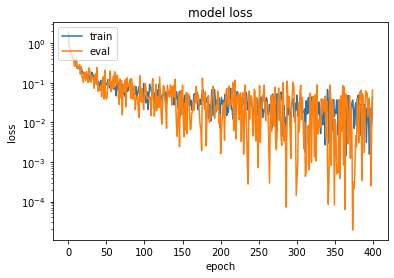

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


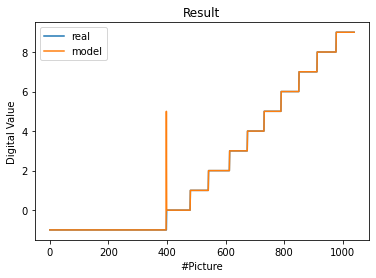

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpszogfg1f\assets


1303008

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpmwbuitos\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpmwbuitos\assets


338112

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ziffer_sortiert_resize/NaN\Ziffer_NaN_3737.jpg NaN 5


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.